# Painting style recognition from images

We will evaluate the performance of CNNs on the same task of painting style recognition from images as last week. 

We will use the same subset of the wikiart dataset of Tan et al., A Deep Convolutional Network for Fine-art Paintings Classification, ICIP 2016. This time, however, we will directly work on the raw images. For reasons of size, I resized them to 32x32 pixels. The data contains:
- X: the vectorized RGB images
- Y: the label of each image

Let us first load the data using a new Dataset class

In [57]:
import numpy as np
import scipy.io as sio # This will allow us to load the data
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class WikiArtDataset(Dataset):

    def __init__(self, mat_file, train, transform=None):
        """
        Args:
            mat_file (string): Path to the mat file with the data
            train (boolean): Is it the training data or the test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        data = sio.loadmat(mat_file)
        self.X = data['X']
        self.Y = data['Y'].squeeze() -1
        Xtrain,Xtest,Ytrain,Ytest = train_test_split(self.X,self.Y,test_size=0.33,random_state=1)
        self.Xtrain = Xtrain.astype(float)
        self.Xtest = Xtest.astype(float)
        self.Ytrain = Ytrain.astype(float)
        self.Ytest = Ytest.astype(float)
        self.train = train
        self.transform = transform

    def __len__(self):
        if self.train:
            return (self.Xtrain.shape[0])
        else:
            return (self.Xtest.shape[0])

    def __getitem__(self, idx):
        
        if self.train:
            img = self.Xtrain[idx,:].reshape(3,32,32).transpose((2,1,0))
            img = (img - 0.5)*2
            sample = {'image': img, 'label': self.Ytrain[idx]}
        else:
            img = self.Xtest[idx,:].reshape(3,32,32).transpose((2,1,0))
            img = (img - 0.5)*2
            sample = {'image': img, 'label': self.Ytest[idx]}
            
        if self.transform:
            sample = self.transform(sample)

        return sample

To use pytorch, we will need to convert the data to tensors. This can be achieved by creating a new transform as a class.

In [58]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(),
                'label': label}

We can now create the training and test set, and directly apply our new transform

In [59]:
trainset = WikiArtDataset(mat_file='wikiart_img_data.mat', train=True, transform=ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = WikiArtDataset(mat_file='wikiart_img_data.mat', train=False, transform=ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Let us visualize a mini-batch of training images

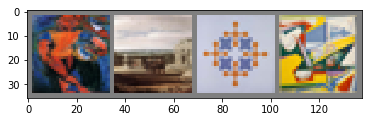

In [60]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# get some random training images
dataiter = iter(trainloader)
samples = dataiter.next()
images = samples['image']

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow(torchvision.utils.make_grid(images))
plt.show()

Create a new CNN. Test different architectures (draw inspiration from the tutorial). (TODO)

In [61]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 32)
        self.fc2 = nn.Linear(32, 8)
        #self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.fc3(x)
        return x

net = Net()

As in the tutorial, we will make use of the cross-entropy as a loss and of SGD with momentum as an optimization method. If time permits, feel free to investigate other strategies (e.g., ADAM)

In [62]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

You can now train your model. Try different number of epochs. To obtain the inputs, you can use "images = data['image']" and for the labels "labels = data['label'].long()". (TODO)

In [97]:
from torch.autograd import Variable
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        images, labels = data['image'], data['label'].long()

        # wrap them in Variable
        images, labels = Variable(images), Variable(labels)

        # clear the gradients of the variables
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 500 == 499:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   500] loss: 1.955
[1,  1000] loss: 1.951
[1,  1500] loss: 1.945
[1,  2000] loss: 1.956
[1,  2500] loss: 1.941
[2,   500] loss: 1.950
[2,  1000] loss: 1.912
[2,  1500] loss: 1.937
[2,  2000] loss: 1.935
[2,  2500] loss: 1.920
[3,   500] loss: 1.910
[3,  1000] loss: 1.906
[3,  1500] loss: 1.910
[3,  2000] loss: 1.904
[3,  2500] loss: 1.907
[4,   500] loss: 1.894
[4,  1000] loss: 1.895
[4,  1500] loss: 1.893
[4,  2000] loss: 1.890
[4,  2500] loss: 1.876
[5,   500] loss: 1.882
[5,  1000] loss: 1.879
[5,  1500] loss: 1.914
[5,  2000] loss: 1.847
[5,  2500] loss: 1.843
Finished Training


Evaluate the model on the test data (TODO)

In [98]:
class_correct, class_total = 0, 0

for data in testloader :
    images, labels = data['image'], data['label'].long()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    for ind, label in enumerate(labels):
        if predicted[ind] == label:
            class_correct += 1
        class_total += 1

print('Accuracy of %2d %%' % (100 * class_correct / class_total))

Accuracy of 28 %
